In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import math

# Load Data

In [2]:
# 資料集由比賽官方提供
# Link : https://tbrain.trendmicro.com.tw/Competitions/Details/31

Train_df      = pd.read_csv(r"dataset\\dataset_1st\\training.csv")
Test_df       = pd.read_csv(r"dataset\\dataset_2nd\\public.csv")

# Feature engineering

In [3]:
def loctm_process(data):
    data['loctm_hh'] = data['loctm'].apply(lambda x: math.floor(x/10000))
    data['loctm_mm'] = data['loctm'].apply(lambda x: math.floor(x/100)-math.floor(x/10000)*100)
    data['loctm_ss'] = data['loctm'].apply(lambda x: math.floor(x)-math.floor(x/100)*100)
    data['weekday'] = data['locdt'] % 7

def mchno_process(train_data, test_data):
    # mchno特店代號
    fraudulent_B_info = train_data.groupby('mchno')['label'].agg(['count', 'mean'])
    fraudulent_B_info.columns = ['詐欺數量', '詐欺比率']

    # 將詐欺比率大於0.2的詐欺比率類別視為黑名單，並將其轉換為二元特徵
    train_data['mchno_fauld_ratio > 0.5'] = train_data['mchno'].isin(fraudulent_B_info[fraudulent_B_info['詐欺比率'] > 0.2].index).astype(int)
    # 將詐欺數量大於200的店家視為黑名單，並將其轉換為二元特徵
    train_data['mchno_fauld_num > 200'] = train_data['mchno'].isin(fraudulent_B_info[fraudulent_B_info['詐欺數量'] > 200].index).astype(int)

    # 找出用cano分組後最多的mchno >> 每張卡有不同的消費習慣，不可能臨時改變
    train_data["freq_mchno"] = train_data["cano"].map(train_data.groupby("cano")['mchno'].agg(lambda x: x.value_counts().idxmax()))
    # 現在的消費是不是在平常最常消費的店家
    train_data["is_freq_mchno_?"] = train_data.apply(lambda row: 1 if row['mchno'] == row["freq_mchno"] else 0, axis=1)

    # 合并训练集和测试集，訓練只使用訓練集資料，避免洩漏
    combined_df = pd.concat([train_data, test_data])

    # 將詐欺比率大於0.2的詐欺比率類別視為黑名單，並將其轉換為二元特徵
    test_data['mchno_fauld_ratio > 0.5'] = test_data['mchno'].isin(fraudulent_B_info[fraudulent_B_info['詐欺比率'] > 0.5].index).astype(int)
    # 將詐欺比率大於0.2的詐欺數量類別視為黑名單，並將其轉換為二元特徵
    test_data['mchno_fauld_num > 200'] = test_data['mchno'].isin(fraudulent_B_info[fraudulent_B_info['詐欺數量'] > 200].index).astype(int)

    # 找出用cano分組後最多的mchno >> 每張卡有不同的消費習慣，不可能臨時改變
    test_data["freq_mchno"] = test_data["cano"].map(combined_df.groupby("cano")['mchno'].agg(lambda x: x.value_counts().idxmax()))
    # 現在的消費是不是在平常最常消費的店家
    test_data["is_freq_mchno_?"] = test_data.apply(lambda row: 1 if row['mchno'] == row["freq_mchno"] else 0, axis=1)

def null_process(data):
        # 找出有空值得列, 並填上-1
        nan_columns = data.isnull().any()
        columns_with_nan = nan_columns[nan_columns].index.tolist()
        data[columns_with_nan] = data[columns_with_nan].fillna(-1)

In [4]:
train_data     = Train_df.copy()
test_data      = Test_df.copy()

In [5]:
null_process(train_data)
null_process(test_data)

loctm_process(train_data)
loctm_process(test_data)

# train_data, test_data 合再一起分析，因為我希望test_data也可以參考過去詐欺數量多的店家，達成類似黑名單的效果
mchno_process(train_data, test_data)

In [6]:
train_data.head(5)

,txkey,locdt,loctm,chid,cano,contp,etymd,mchno,acqic,mcc,...,flg_3dsmk,label,loctm_hh,loctm_mm,loctm_ss,weekday,mchno_fauld_ratio > 0.5,mchno_fauld_num > 200,freq_mchno,is_freq_mchno_?
0,1c09727c939eb69ead2a4ce4072b8aa18992a64f01fcb4...,46,101812,84d2dc85d4da6a7fa284a11a4290d7e9a969163dcb4d82...,3dd5bf1e29e5e0baa789ce692fe5dbd34ff05173acf351...,5,1.0,cad752c5d05d2bdcc30d64fa4e68404c2d1f7be5d14d52...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,375.0,...,0,0,10,18,12,4,0,1,dd280b4f35a02701142ba7de47abb9736deca3eed86474...,0
1,2043f245a93bc6328dac964d6dbc89f13a0346062c194d...,17,85509,9a8cf5d0afd729cb7876f6b3172152c7c9c6fabd40515c...,8cb13f9b38c7bbc02d210e580dcbbcbb6c95bf18bc3320...,5,8.0,4356c6642ef6e837543b577c7ee3ffa92b4b8fcfb57254...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,282.0,...,0,0,8,55,9,3,0,1,4356c6642ef6e837543b577c7ee3ffa92b4b8fcfb57254...,1
2,e4853710290a8409279f3279f8032ae670824bd19aa173...,44,212641,dcc1389a5765d6f53152cf85970fbe78a83fd3d1c299b0...,1ec32868e5e1d5ff8df56737c2a91326cbfe3364382de6...,5,4.0,5b7eff061f8896aac4339ea35c25f8bb956a43bc486460...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,288.0,...,0,0,21,26,41,2,0,0,5b7eff061f8896aac4339ea35c25f8bb956a43bc486460...,1
3,74d811b1dbc28b22b73ba2c79bb6033791d913b6d27a25...,42,102702,577f2329d1eccd59ba0abaf6113bb78dcd575badcbc57f...,4359dca1ac6a835eceb2bc0dd6b0b710f030c3499126e9...,5,1.0,cad752c5d05d2bdcc30d64fa4e68404c2d1f7be5d14d52...,36684976be1f529e6e2a32c9edab4cf8e364b2b916ae2c...,375.0,...,0,0,10,27,2,0,0,1,cad752c5d05d2bdcc30d64fa4e68404c2d1f7be5d14d52...,1
4,68ca182343969d429d79a34e532bc1ca7a3cc032c2ad81...,31,185737,fff6b4126c40620b1fbb11d4de02cd67b9e95071caa40b...,a3837f2905383f235a72679482c5f02e40f2a8ca29750d...,5,5.0,50d5b02ce3fc88723438c2a29cfdb04be4a1a11280ddb6...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,406.0,...,0,0,18,57,37,3,0,1,48675480a5edda3511920982ec3ae71f242231c2a3badb...,0


In [7]:
# 丟棄標籤txkey
train_x = train_data.drop(['label', 'txkey'],axis = 1)
train_y = train_data['label']

testing_x = test_data.drop(['label', 'txkey'],axis = 1)
testing_y = test_data['label']

In [8]:
# CatBoostClassifier可以直接分析str的功能，因此不做函數映射(hash)，直接轉換成str
category = ['contp','etymd','mchno','acqic','mcc','ecfg','insfg','bnsfg','stocn','scity','stscd','ovrlt','flbmk','hcefg','csmcu','flg_3dsmk',
                'chid','cano', 'mchno_fauld_ratio > 0.5', 'mchno_fauld_num > 200','freq_mchno', 'is_freq_mchno_?']

train_x[category] = train_x[category].astype(str)
testing_x[category] = testing_x[category].astype(str)

In [31]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, stratify=train_y, random_state=seed, test_size=0.2)

In [32]:
model = CatBoostClassifier(learning_rate=0.3, 
                           depth=12, 
                           cat_features=category, 
                           task_type="GPU", 
                           iterations=150, 
                           verbose=10, 
                           eval_metric='F1',
                           random_seed=seed, 
                           early_stopping_rounds=50, 
                           use_best_model=True
                           )

model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4766802	test: 0.4896612	best: 0.4896612 (0)	total: 509ms	remaining: 1m 15s
10:	learn: 0.9084644	test: 0.9369765	best: 0.9369765 (10)	total: 3.96s	remaining: 50.1s
20:	learn: 0.9234871	test: 0.9435087	best: 0.9439561 (19)	total: 7.41s	remaining: 45.5s
30:	learn: 0.9312394	test: 0.9467180	best: 0.9467180 (30)	total: 10.9s	remaining: 41.7s
40:	learn: 0.9362838	test: 0.9480603	best: 0.9481790 (38)	total: 14.3s	remaining: 38s
50:	learn: 0.9413513	test: 0.9483643	best: 0.9486933 (41)	total: 17.8s	remaining: 34.5s
60:	learn: 0.9448195	test: 0.9487344	best: 0.9491906 (54)	total: 21.2s	remaining: 30.9s
70:	learn: 0.9486904	test: 0.9493235	best: 0.9493235 (70)	total: 24.7s	remaining: 27.5s
80:	learn: 0.9516051	test: 0.9512156	best: 0.9512156 (80)	total: 28.2s	remaining: 24s
90:	learn: 0.9544710	test: 0.9506232	best: 0.9512156 (80)	total: 31.7s	remaining: 20.6s
100:	learn: 0.9560120	test: 0.9509663	best: 0.9512156 (80)	total: 35.2s	remaining: 17.1s
110:	learn: 0.9595061	test: 0.952000

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate model
ytrain_pred = model.predict(train_x)
print("ytrain_pred Classification Report: ")
print(classification_report(train_y, ytrain_pred))
print("Confusion Matrix: ")
print(confusion_matrix(train_y, ytrain_pred))

print("*"*20)

y_pred = model.predict(testing_x)
print("y_pred Classification Report: ")
print(classification_report(testing_y, y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(testing_y, y_pred))

ytrain_pred Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   8656497
           1       0.99      0.97      0.98     32029

    accuracy                           1.00   8688526
   macro avg       1.00      0.99      0.99   8688526
weighted avg       1.00      1.00      1.00   8688526

Confusion Matrix: 
[[8656224     273]
 [    830   31199]]
********************
y_pred Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    606856
           1       0.93      0.68      0.79      2184

    accuracy                           1.00    609040
   macro avg       0.97      0.84      0.89    609040
weighted avg       1.00      1.00      1.00    609040

Confusion Matrix: 
[[606752    104]
 [   705   1479]]


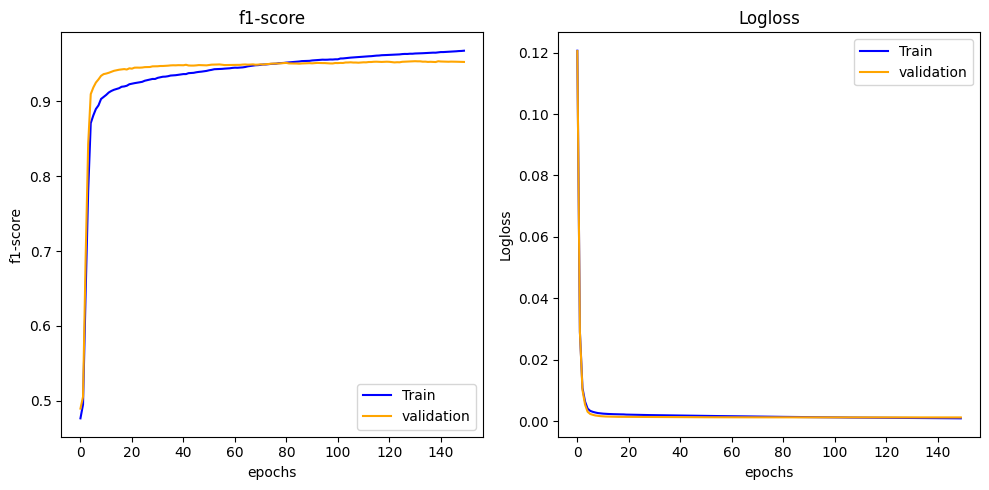

In [97]:
import matplotlib.pyplot as plt

# Extract data
result = model.evals_result_

epochs = len(result['learn']['Logloss'])
x_axis = range(0, epochs)

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot f1-score
ax1.plot(x_axis, result['learn']['F1'], label='Train', color='blue')
ax1.plot(x_axis, result['validation']['F1'], label='validation', color='orange')
ax1.set_title('f1-score')
ax1.legend()
ax1.set_ylabel('f1-score')
ax1.set_xlabel('epochs')

# Plot Logloss
ax2.plot(x_axis, result['learn']['Logloss'], label='Train', color='blue')
ax2.plot(x_axis, result['validation']['Logloss'], label='validation', color='orange')
ax2.set_title('Logloss')
ax2.legend()
ax2.set_ylabel('Logloss')
ax2.set_xlabel('epochs')

from datetime import datetime
# 获取当前时间
current_time = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
# 替换文件名中的冒号为下划线
file_name = f"plot_{current_time.replace(':', '_')}.png"

# 保存图表为图像文件
plt.savefig(file_name)
plt.tight_layout()
plt.show()


In [42]:
importances = model.get_feature_importance ()

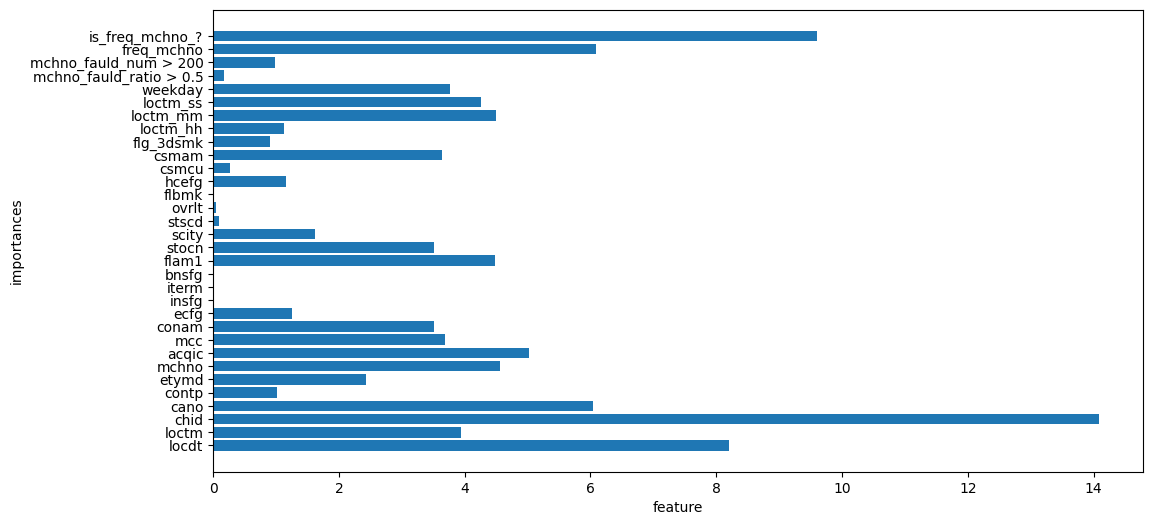

In [99]:
import matplotlib.pyplot as plt

# 創建子圖
fig, ax = plt.subplots(figsize=(12, 6))

# 繪製條形圖
ax.barh(train_x.columns, importances)
plt.xlabel("feature")
plt.ylabel("importances")

current_time = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
# 替换文件名中的冒号为下划线
file_name = f"plot_{current_time.replace(':', '_')}.png"

plt.savefig(file_name)
plt.show()

#消融實驗(不使用特徵工程, 字串特徵)

In [51]:
train_data_     = Train_df.copy()
test_data_      = Test_df.copy()

In [52]:
null_process(train_data_)
null_process(test_data_)

In [64]:
# 丟棄標籤txkey
train_x_ = train_data_.drop(['label', 'txkey', 'chid','cano'],axis = 1)
train_y_ = train_data_['label']

testing_x_ = test_data_.drop(['label', 'txkey', 'chid','cano'],axis = 1)
testing_y_ = test_data_['label']

In [65]:
# CatBoostClassifier可以直接分析str的功能，因此不做函數映射(hash)，直接轉換成str
category = ['contp','etymd','mchno','acqic','mcc','ecfg','insfg','bnsfg','stocn','scity','stscd','ovrlt','flbmk','hcefg','csmcu','flg_3dsmk'
               ]

train_x_[category] = train_x_[category].astype(str)
testing_x_[category] = testing_x_[category].astype(str)
X_train2, X_test2, y_train2, y_test2 = train_test_split(train_x_, train_y_, stratify=train_y_, random_state=seed, test_size=0.2)

In [66]:
X_train2.head(5)

,locdt,loctm,contp,etymd,mchno,acqic,mcc,conam,ecfg,insfg,...,flam1,stocn,scity,stscd,ovrlt,flbmk,hcefg,csmcu,csmam,flg_3dsmk
1858015,44,185624,5,5.0,c1cc43adea236997997beb029945237f31daa18c0da45c...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,273.0,35.0,1,0,...,35,0.0,15759.0,-1.0,0,0,6.0,70.0,35,0
1810202,47,144750,5,5.0,bd2b3523b4ecd652445b75ea7583c92f6f02af3971251b...,70dac5b1dfde828f556a93321a649df72891db35430588...,272.0,321.0,1,0,...,321,42.0,12381.0,-1.0,0,0,6.0,70.0,321,0
5233613,38,101822,4,1.0,4d7ccd00c86844f54a3db3fbc2b9b6d594e33102996485...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,375.0,3598.0,0,0,...,3594,0.0,15759.0,-1.0,0,0,6.0,70.0,3594,0
1603834,5,140656,5,4.0,0b8434734d71d8867c24fcf1cc08eaa0689648c916e7cb...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,369.0,646.0,0,0,...,648,0.0,15759.0,-1.0,0,0,6.0,70.0,648,0
3388947,43,103114,5,1.0,20c62f4d69405bc669c78acdccc99719601ff0490e9325...,13624921218432873e0cfa1966e41376844b387695a0ee...,227.0,1929.0,0,0,...,1929,0.0,14181.0,-1.0,0,0,6.0,70.0,1929,0


In [69]:
model_ = CatBoostClassifier(cat_features=category,
                            eval_metric='F1',
                            random_seed=seed, 
                            iterations=1000,
                            early_stopping_rounds=50, 
                            task_type="GPU")

model_.fit(X_train2, y_train2, eval_set=(X_test2, y_test2), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.03357
0:	learn: 0.3773264	test: 0.3871406	best: 0.3871406 (0)	total: 887ms	remaining: 14m 46s
1:	learn: 0.3446509	test: 0.3536198	best: 0.3871406 (0)	total: 1.48s	remaining: 12m 16s
2:	learn: 0.3456208	test: 0.3550477	best: 0.3871406 (0)	total: 2.08s	remaining: 11m 31s
3:	learn: 0.3602869	test: 0.3692308	best: 0.3871406 (0)	total: 2.66s	remaining: 11m 3s
4:	learn: 0.3672095	test: 0.3754895	best: 0.3871406 (0)	total: 3.34s	remaining: 11m 5s
5:	learn: 0.3648668	test: 0.3738728	best: 0.3871406 (0)	total: 3.83s	remaining: 10m 34s
6:	learn: 0.3622166	test: 0.3686904	best: 0.3871406 (0)	total: 4.48s	remaining: 10m 35s
7:	learn: 0.3628362	test: 0.3710091	best: 0.3871406 (0)	total: 5.12s	remaining: 10m 35s
8:	learn: 0.3690473	test: 0.3788791	best: 0.3871406 (0)	total: 5.72s	remaining: 10m 30s
9:	learn: 0.3727749	test: 0.3853360	best: 0.3871406 (0)	total: 6.39s	remaining: 10m 32s
10:	learn: 0.3771627	test: 0.3910086	best: 0.3910086 (10)	total: 6.96s	remaining: 10m 25s
11:

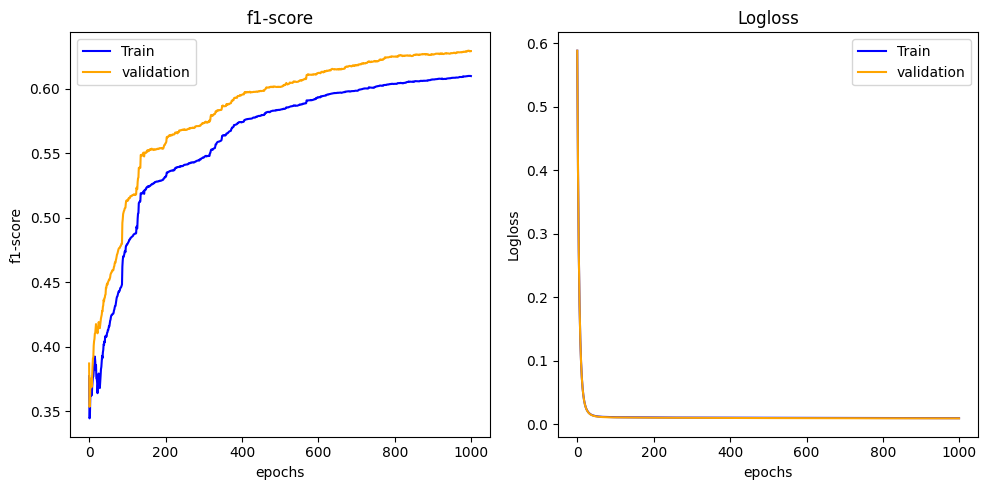

In [96]:
import matplotlib.pyplot as plt

# Extract data
result = model_.evals_result_

epochs = len(result['learn']['Logloss'])
x_axis = range(0, epochs)

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot f1-score
ax1.plot(x_axis, result['learn']['F1'], label='Train', color='blue')
ax1.plot(x_axis, result['validation']['F1'], label='validation', color='orange')
ax1.set_title('f1-score')
ax1.legend()
ax1.set_ylabel('f1-score')
ax1.set_xlabel('epochs')

# Plot Logloss
ax2.plot(x_axis, result['learn']['Logloss'], label='Train', color='blue')
ax2.plot(x_axis, result['validation']['Logloss'], label='validation', color='orange')
ax2.set_title('Logloss')
ax2.legend()
ax2.set_ylabel('Logloss')
ax2.set_xlabel('epochs')

from datetime import datetime
# 获取当前时间
current_time = datetime.now().strftime("%Y-%m-%d %H-%M-%S")

# # 将当前时间作为标题
# plt.title(f"basic model")

# 替换文件名中的冒号为下划线
file_name = f"plot_{current_time.replace(':', '_')}.png"

# 保存图表为图像文件
plt.savefig(file_name)
plt.tight_layout()
plt.show()

In [70]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate model
ytrain_pred_ = model_.predict(train_x_)
print("ytrain_pred_ Classification Report: ")
print(classification_report(train_y_, ytrain_pred_))
print("Confusion Matrix: ")
print(confusion_matrix(train_y_, ytrain_pred_))

print("*"*20)

y_pred_ = model_.predict(testing_x_)
print("y_pred_ Classification Report: ")
print(classification_report(testing_y_, y_pred_))
print("Confusion Matrix: ")
print(confusion_matrix(testing_y_, y_pred_))

ytrain_pred_ Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   8656497
           1       0.86      0.52      0.65     32029

    accuracy                           1.00   8688526
   macro avg       0.93      0.76      0.83   8688526
weighted avg       1.00      1.00      1.00   8688526

Confusion Matrix: 
[[8653788    2709]
 [  15229   16800]]
********************
y_pred_ Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    606856
           1       0.65      0.37      0.47      2184

    accuracy                           1.00    609040
   macro avg       0.83      0.68      0.73    609040
weighted avg       1.00      1.00      1.00    609040

Confusion Matrix: 
[[606433    423]
 [  1386    798]]
